In [20]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt

In [21]:

class ImageToImageDataset(Dataset):
    def __init__(self, input_dir, output_dir, transform=None):
        self.input_paths = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir)])
        self.output_paths = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir)])
        self.transform = transform

    def __len__(self):
        return len(self.input_paths)

    def __getitem__(self, idx):
        input_img = Image.open(self.input_paths[idx]).convert("RGB")
        output_img = Image.open(self.output_paths[idx]).convert("RGB")
        if self.transform:
            input_img = self.transform(input_img)
            output_img = self.transform(output_img)
        return input_img, output_img

In [22]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = ImageToImageDataset("input", "output", transform)

In [24]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [26]:
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

In [27]:
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")

Epoch 20/20 | Train Loss: 0.0051 | Val Loss: 0.0067


In [28]:
torch.save(model.state_dict(), "autoencoder_blurimage.pth")

In [29]:
def show_images(inputs, outputs, targets, num_images=4):
    inputs = inputs.cpu()
    outputs = outputs.cpu()
    targets = targets.cpu()
    plt.figure(figsize=(12, num_images * 3))

    for i in range(num_images):
        plt.subplot(num_images, 3, i*3+1)
        plt.imshow(torch.permute(inputs[i], (1,2,0)))
        plt.title("Input")
        plt.axis("off")

        plt.subplot(num_images, 3, i*3+2)
        plt.imshow(torch.permute(outputs[i], (1,2,0)))
        plt.title("Hasil Model")
        plt.axis("off")

        plt.subplot(num_images, 3, i*3+3)
        plt.imshow(torch.permute(targets[i], (1,2,0)))
        plt.title("Target Output")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

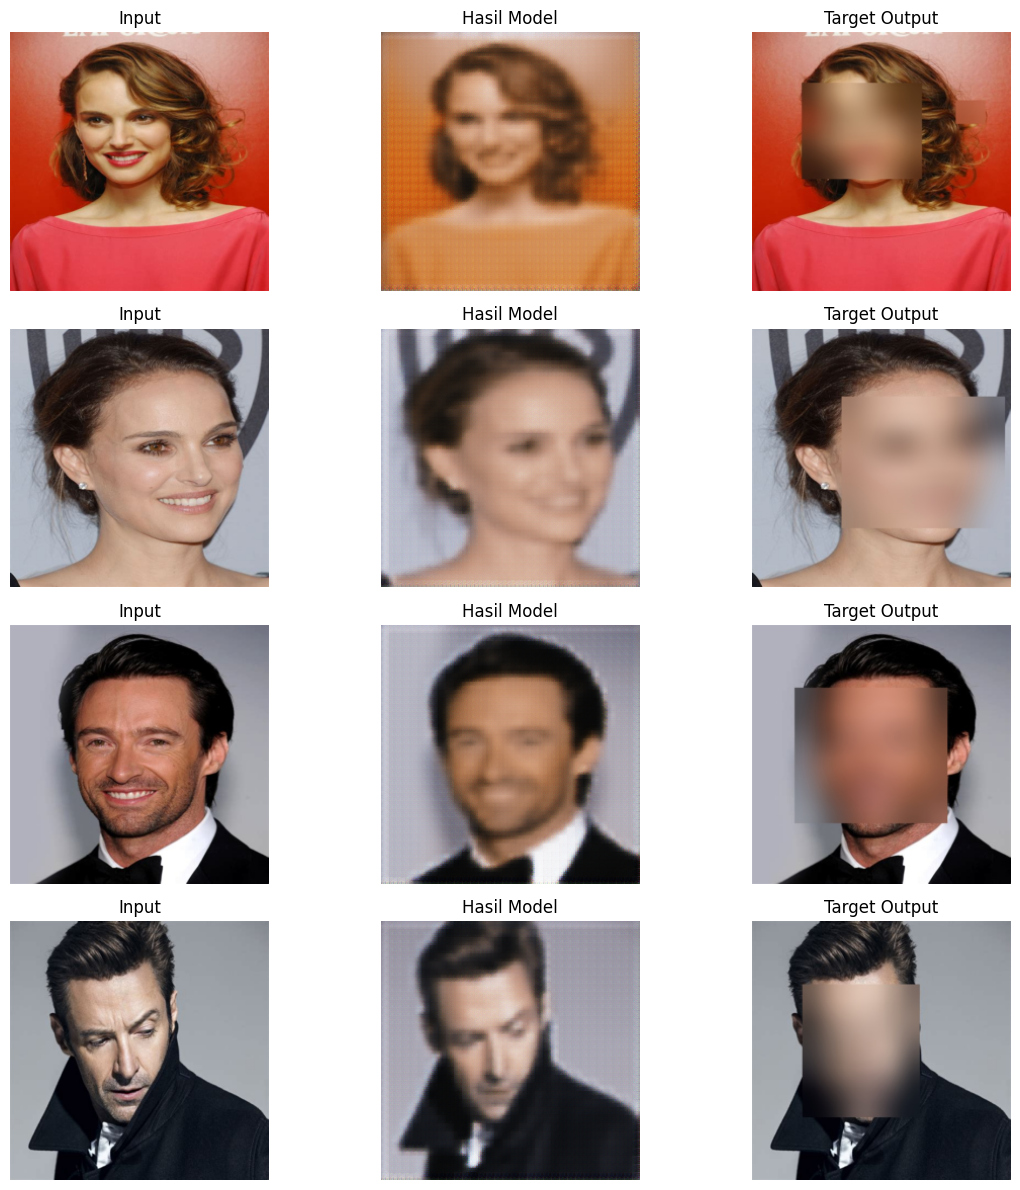

In [30]:
model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        show_images(x, pred, y, num_images=min(4, x.size(0)))
        break